In [253]:
using Flight.FlightCore.Systems
using Flight.FlightCore.Plotting

using Flight.FlightLib
using Flight.FlightAircraft
using Flight.FlightAircraft.C172X.C172XControl
using Flight.FlightLib.Control.Discrete: PIDParams
using Flight.FlightLib.Control.PIDOpt: Settings, Metrics, optimize_PID, build_PID, check_results

using UnPack
using ControlSystems
using RobustAndOptimalControl
using ComponentArrays
using LinearAlgebra

We start by taking a look at the linearized lateral model:

In [ ]:
global_search = false

ac = Cessna172Xv0(NED()) |> System #linearization requires NED kinematics

design_point = C172.TrimParameters()
# design_point = C172.TrimParameters(EAS = 28)
# design_point = C172.TrimParameters(EAS = 25, flaps = 1.0)

#full-state lateral model
lss_full = Control.Continuous.LinearizedSS(ac, design_point; model = :lat);
P_full = named_ss(lss_full);

x_labels_full = keys(lss_full.x0) |> collect
y_labels_full = keys(lss_full.y0) |> collect
u_labels = keys(lss_full.u0) |> collect

lss_full.A[:ψ, :] |> display
lss_full.A[:, :ψ] |> display
lss_full.C[:, :ψ] |> display

ComponentVector{Float64}(p = 0.0, r = 1.0298356541455838, ψ = 6.833806520914203e-9, φ = -4.029756734303856e-6, v_x = -1.1158920779254215e-18, v_y = -3.8581742578111744e-8, β_filt = 0.0, ail_p = 0.0, rud_p = 0.0)

ComponentVector{Float64}(p = -8.695941362824033e-8, r = -2.245876565276639e-6, ψ = 6.833806520914203e-9, φ = 2.8594560656766684e-8, v_x = 0.0009161682005638383, v_y = -1.3761866568096082e-5, β_filt = 0.0, ail_p = 0.0, rud_p = 0.0)

ComponentVector{Float64}(p = 0.0, r = 0.0, ψ = 1.0, φ = 0.0, v_x = 0.0, v_y = 0.0, β_filt = 0.0, ail_p = 0.0, rud_p = 0.0, f_y = -6.05359673500061e-9, β = 0.0, χ = 1.0, aileron_cmd = 0.0, rudder_cmd = 0.0)

As one would expect, heading is nearly a pure integral of yaw rate. This will be a problem when designing a LQR tracker for which the choice of command variables involves non-zero steady state yaw rate. Since we cannot maintain constant heading with an arbitrary yaw rate, true static equilibrium will not exist and the block $H_x F^{-1} G$ in the feedforward gain matrix required for tracking such command variables will be singular. This would not be an issue if we picked for instance $\chi$ and $\beta$ as command variables, because true equilibrium exists for an arbitrary combination of the two. However, this is not an appealing choice, because we would like to be able to control the roll axis explicitly, rather than implicitly through $\chi$.

To handle this issue, we could partition the state and work with quasi-static equilibrium. However, since this is annoying, and the coupling of $\psi$ into the remaining states is extremely weak, we can simply drop $\psi$ from the state, design the LQR trackers on the reduced plant, and then connect them back to the full plant. 

In [255]:
x_labels_red = copy(x_labels_full)
y_labels_red = copy(y_labels_full)

x_labels_red = deleteat!(x_labels_red, findfirst(isequal(:ψ), x_labels_red))
y_labels_red = deleteat!(y_labels_red, findfirst(isequal(:ψ), y_labels_red))

#we should also remove χ because of its coupling to ψ
y_labels_red = deleteat!(y_labels_red, findfirst(isequal(:χ), y_labels_red))

lss_red = Control.Continuous.submodel(lss_full; x = x_labels_red, u = u_labels, y = y_labels_red)
P_red = named_ss(lss_red);

In [256]:
dampreport(P_full)
dampreport(P_red)
controllability(P_red)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -1.88e-05          |  1            |  1.88e-05     |  2.99e-06     |  5.32e+04     |
| +0.0993            |  -1           |  0.0993       |  0.0158       |  -10.1        |
| -0.622             |  1            |  0.622        |  0.099        |  1.61         |
| -0.499  ±   1.42im |  0.332        |  1.51         |  0.24         |  2            |
| -5.1               |  1            |  5.1          |  0.811        |  0.196        |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -50                |  1            |  50           |  7.96         |  0.02         |
|        Pole        |   Damping     |   Fr

(iscontrollable = true, ranks = [8, 8, 8, 8, 8, 8, 8, 8], sigma_min = [0.046561584914798414, 10.444123336418226, 10.444123336418226, 0.8968710891967636, 0.041792933338113396, 0.3656274220241463, 0.3656274220241463, 0.2889925729297014])

We see that removing $\psi$ as a state eliminates an extremely slow pole, possibly geodesy-related. The remaining poles are virtually unaffected. Also, it significantly improves the condition of the dynamics matrix:

In [257]:
cond(P_full.A) |> display
cond(P_red.A) |> display

9.816928185111571e6

2214.2423919702865

In [258]:
#ensure consistency in component selection and ordering between our design model
#and avionics implementation for state and control vectors
@assert tuple(x_labels_red...) === propertynames(C172XControl.XLat())
# @assert tuple(u_labels_red...) === propertynames(C172XControl.ULat())

x_trim = lss_red.x0
u_trim = lss_red.u0

n_x = length(x_labels_red)
n_u = length(u_labels)

2

# 1. Stability Augmentation

For pure stability augmentation, we must not impose aileron and rudder as command variables, because
it is not feasible to achieve a steady state for arbitrary aileron and rudder positions. Therefore,
we simply compute a suitable feedback matrix to tame the lateral modes, and leave the feedforward
matrix as a unit passthrough.

In [259]:
@unpack v_x, v_y = lss_red.x0
v_norm = norm([v_x, v_y])

#weight matrices
Q = C172XControl.XLat(p = 0, r = 0.1, φ = 0.1, v_x = 0/v_norm, v_y = 0/v_norm, β_filt = 0, ail_p = 0, rud_p = 0) |> diagm
R = C172XControl.ULat(aileron_cmd = 0.1, rudder_cmd = 0.01) |> diagm

#feedback gain matrix
C_fbk = lqr(P_red, Q, R)

#useful signal labels for connections
z_labels = [:aileron_cmd, :rudder_cmd]
z_trim = lss_red.y0[z_labels]
n_z = length(z_labels)

#passthrough feedforward
C_fwd = Matrix{Float64}(I, n_z, n_z)

#no integral control
C_int = zeros(n_u, n_z)

u_labels_fbk = Symbol.(string.(u_labels) .* "_fbk")
u_labels_fwd = Symbol.(string.(u_labels) .* "_fwd")
u_labels_sum = Symbol.(string.(u_labels) .* "_sum")
z_labels_sp = Symbol.(string.(z_labels) .* "_sp")

C_fbk_ss = named_ss(ss(C_fbk); u = x_labels_red, y = u_labels_fbk)
C_fwd_ss = named_ss(ss(C_fwd), u = z_labels_sp, y = u_labels_fwd)

#summing junctions
aileron_sum = sumblock("aileron_cmd_sum = aileron_cmd_fwd- aileron_cmd_fbk")
rudder_sum = sumblock("rudder_cmd_sum = rudder_cmd_fwd - rudder_cmd_fbk")

connections_fbk = vcat(
    Pair.(x_labels_red, x_labels_red),
    Pair.(u_labels_fbk, u_labels_fbk),
    Pair.(u_labels_fwd, u_labels_fwd),
    Pair.(u_labels_sum, u_labels),
    )

P_ar = connect([P_full, aileron_sum, rudder_sum, C_fbk_ss, C_fwd_ss],
                connections_fbk; w1 = z_labels_sp, z1 = P_full.y)

display(C_fbk)

2×8 Matrix{Float64}:
 0.151206  0.359626  0.865805  0.00312478  …  0.0  0.028227   0.00353569
 0.230167  2.46804   1.42174   0.00786045     0.0  0.0353569  0.0393808

In [260]:
dampreport(P_red)
dampreport(P_ar)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| +0.0993            |  -1           |  0.0993       |  0.0158       |  -10.1        |
| -0.622             |  1            |  0.622        |  0.099        |  1.61         |
| -0.499  ±   1.42im |  0.332        |  1.51         |  0.24         |  2            |
| -5.1               |  1            |  5.1          |  0.811        |  0.196        |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -50                |  1            |  50           |  7.96         |  0.02         |
|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (r

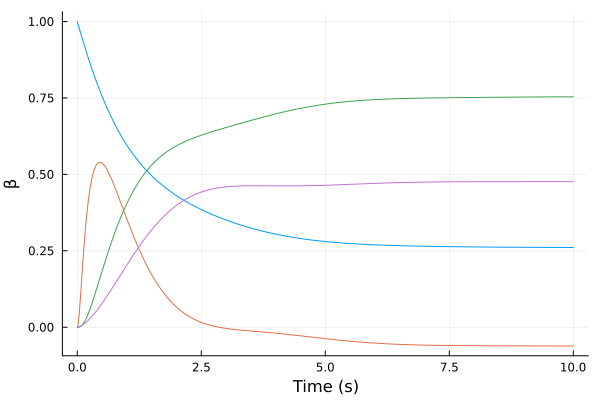

In [261]:
# a2a = P_red[:aileron_cmd, :aileron_cmd]
# a2p = P_red[:p, :aileron_cmd]
# a2φ = P_red[:φ, :aileron_cmd]
a2a_ar = P_ar[:aileron_cmd, :aileron_cmd_sp]
a2p_ar = P_ar[:p, :aileron_cmd_sp]
a2φ_ar = P_ar[:φ, :aileron_cmd_sp]
a2β_ar = P_ar[:β, :aileron_cmd_sp]
step(a2a_ar, 10) |> plot
step(a2p_ar, 10) |> plot!
step(a2φ_ar, 10) |> plot!
step(a2β_ar, 10) |> plot!
# step(a2r_ar, 10) |> plot!
# step(a2p_ar, 10) |> plot!
# step(a2φ_ar, 10) |> plot!
# step(a2φ, 10) |> plot!

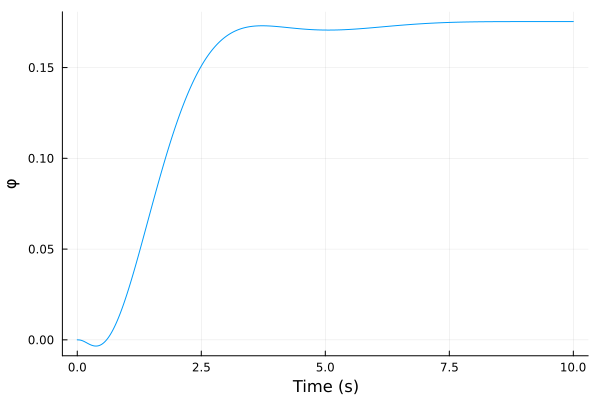

In [262]:
a2r = P_red[:r, :aileron_cmd]
r2r = P_red[:r, :rudder_cmd]
a2r_ar = P_ar[:r, :aileron_cmd_sp]
r2r_ar = P_ar[:r, :rudder_cmd_sp]
r2φ_ar = P_ar[:φ, :rudder_cmd_sp]
# step(a2r, 10) |> plot
# step(r2r, 10) |> plot
# step(r2r_ar, 10) |> plot!
step(r2φ_ar, 10) |> plot
# step(a2r_fbk, 10) |> plot!

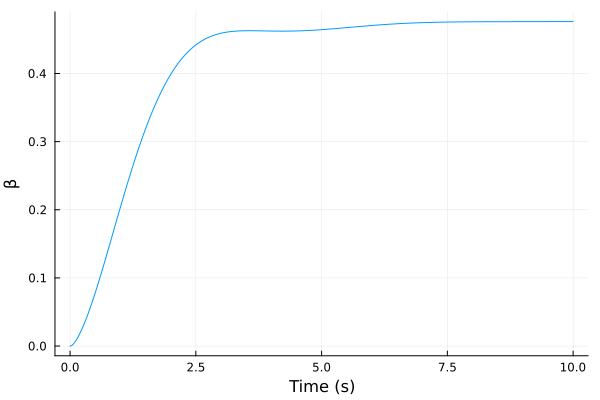

In [263]:
a2β_ar = P_ar[:β, :aileron_cmd_sp]
# r2β_ar = P_ar[:β, :rudder_cmd_sp]
step(a2β_ar, 10) |> plot
# step(r2β_ar, 10) |> plot

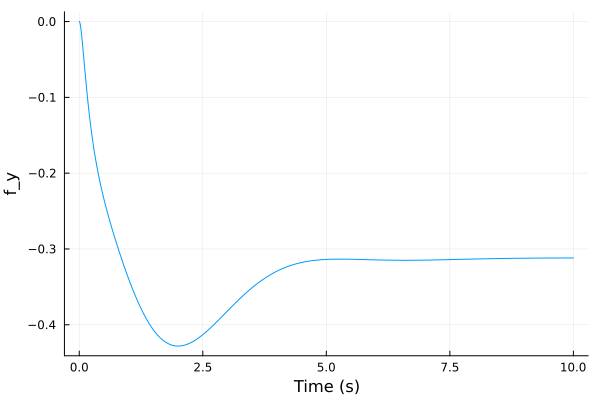

In [264]:
a2f_ar = P_ar[:f_y, :aileron_cmd_sp]
step(a2f_ar, 10) |> plot

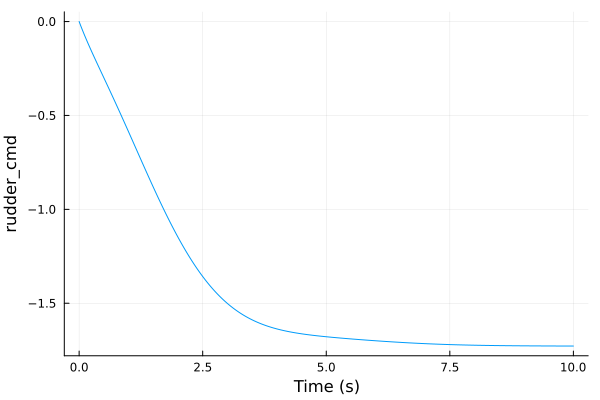

In [265]:
ail2rud_ar = P_ar[:rudder_cmd, :aileron_cmd_sp]
step(ail2rud_ar, 10) |> plot

## 1.1. Turn Coordination ($\beta \rightarrow r$)

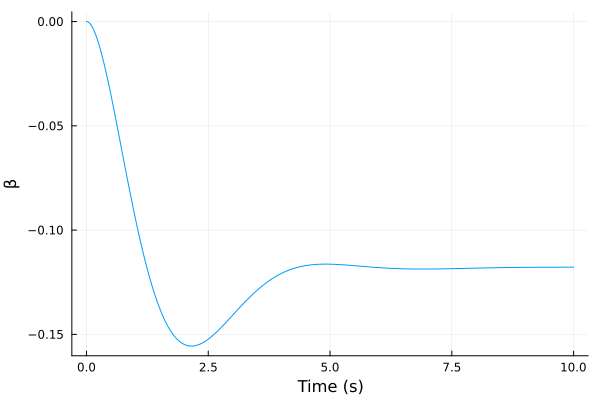

In [266]:
P_r2β = P_ar[:β, :rudder_cmd_sp]
step(P_r2β, 10) |> plot

In [267]:
P_r2β_opt = -P_r2β;

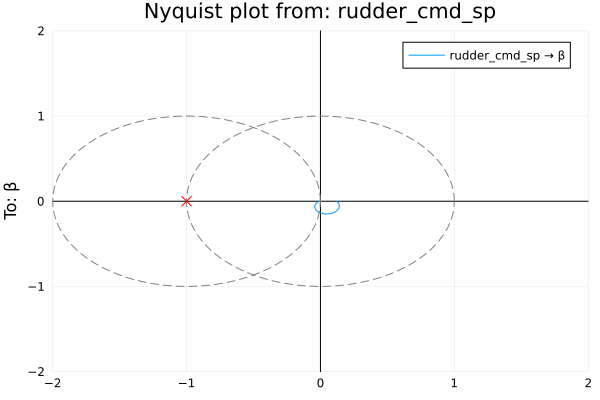

In [268]:
nyquistplot(P_r2β_opt; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))

In [269]:
t_sim_β2r = 20
lower_bounds = PIDParams(; k_p = 0.01, k_i = 0.000, k_d = 0.0, τ_f = 0.1)
upper_bounds = PIDParams(; k_p = 10.0, k_i = 20, k_d = 5, τ_f = 0.1)
settings = Settings(; t_sim = t_sim_β2r, lower_bounds, upper_bounds)
weights = Metrics(; Ms = 3.0, ∫e = 5.0, ef = 1.0, ∫u = 0.0, up = 0.0)
params_0 = PIDParams(; k_p = 1, k_i = 0.1, k_d = 0.0, τ_f = 0.01)

β2r_results = optimize_PID(P_r2β_opt; params_0, settings, weights, global_search)
β2r_pid = build_PID(β2r_results.params)
C_β2r = -β2r_pid
C_β2r = named_ss(ss(C_β2r), :C_β2r; u = :β_err, y = :rudder_cmd_sp)
L_β2r = series(C_β2r, P_r2β);

@unpack k_p, k_i, k_d, τ_f, T_i, T_d = β2r_results.params
@show k_p, k_i, k_d, τ_f, T_i, T_d
@show β2r_results.metrics
@show β2r_results.exit_flag;

(k_p, k_i, k_d, τ_f, T_i, T_d) = (2.352521339130895, 7.460043717638881, 2.2943137068727766, 0.1, 0.31534953790799936, 0.9752573414362217)
β2r_results.metrics = [1.0511309589564144, 0.056898096491775935, 4.460465840205874e-5, 7.072983741489804, 24.29565840785866]
β2r_results.exit_flag = :ROUNDOFF_LIMITED


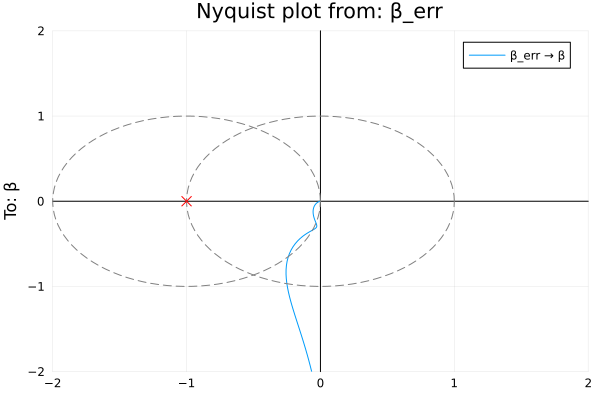

In [270]:
nyquistplot(L_β2r; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))


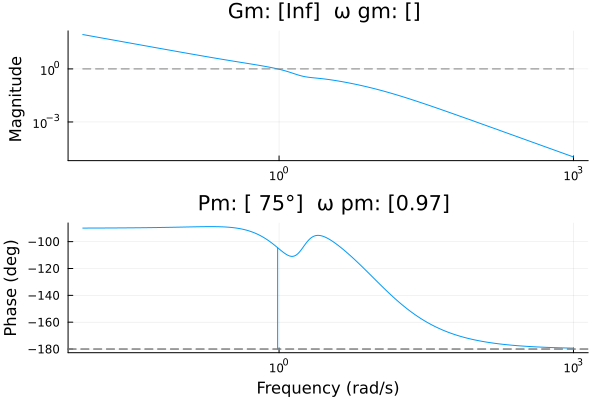

In [271]:
marginplot(L_β2r)

StepInfo:
Initial value:     0.000
Final value:       1.000
Step size:         1.000
Peak:              1.000
Peak time:        19.999 s
Overshoot:          0.00 %
Undershoot:         0.00 %
Settling time:     6.501 s
Rise time:         1.957 s


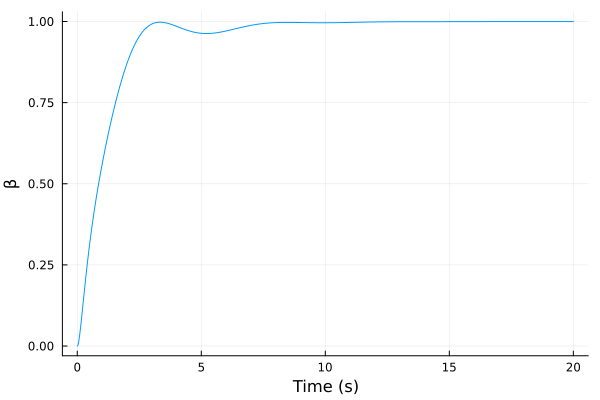

In [272]:
T_β2r = output_comp_sensitivity(P_r2β, C_β2r)
T_β2r_step = step(T_β2r, t_sim_β2r)
stepinfo(T_β2r_step) |> display
T_β2r_step |> plot

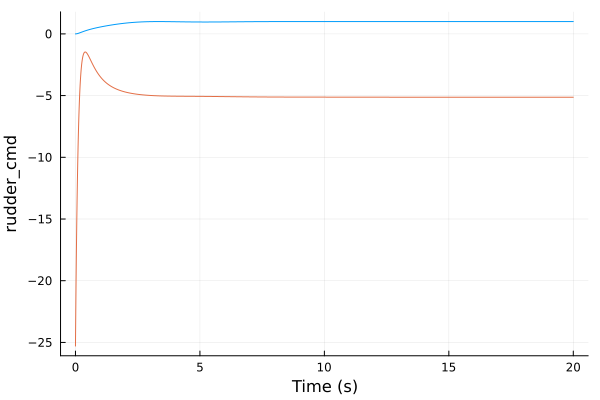

In [273]:
β2r_sum = sumblock("β_err = β_sp - β")
P_aβ = connect([P_ar, β2r_sum, C_β2r], [:β_err=>:β_err, :β=>:β, :rudder_cmd_sp=>:rudder_cmd_sp], w1 = [:aileron_cmd_sp, :β_sp], z1 = P_ar.y)

#check we get the same response as with the SISO closed loop
βsp2β = P_aβ[:β, :β_sp]
βsp2r = P_aβ[:rudder_cmd, :β_sp]
step(βsp2β, t_sim_β2r) |> plot
step(βsp2r, t_sim_β2r) |> plot!

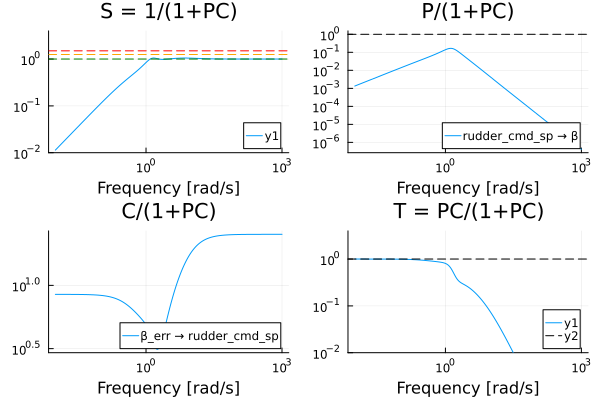

In [274]:
gangoffourplot(P_r2β, C_β2r)

To avoid transients on mode changes, we want the initial $r_{cmd,sp}$ output from the $\beta 2r$
controller to match the current value of $r_{cmd,sp}$ at the SAS input when $\beta_{sp}$ matches the current $\beta$.

Whenever $\beta 2r$ is enabled after a mode change, we reset the PID. Then we set the PID integrator's state to the appropriate value to achieve the required $r_{cmd,sp}$. Noting the sign inversion, we have:
$$ y_{pid} = k_p (\beta_{sp} - \beta) + k_i x_{i0} = k_i x_{i0} $$
$$ r_{cmd,sp} = -y_{pid}$$

Therefore:
$$x_{i0} = y_{pid} / k_i = -r_{cmd, sp}/k_i
$$

where $r_{cmd,sp}$ is read from the SAS input.

# 2. CAS

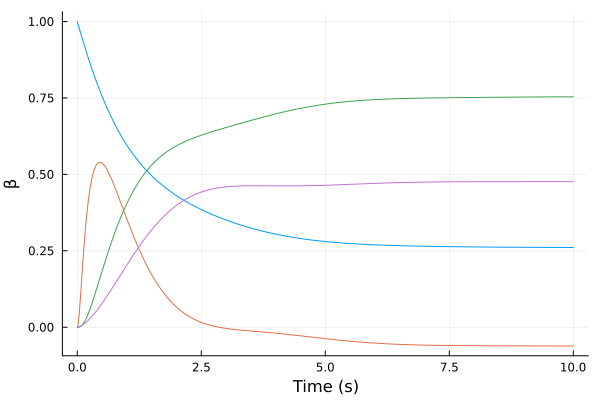

In [275]:
a2a_ar = P_ar[:aileron_cmd, :aileron_cmd_sp]
a2p_ar = P_ar[:p, :aileron_cmd_sp]
a2φ_ar = P_ar[:φ, :aileron_cmd_sp]
a2φ_β = P_ar[:β, :aileron_cmd_sp]
step(a2a_ar, 10) |> plot
step(a2p_ar, 10) |> plot!
step(a2φ_ar, 10) |> plot!
step(a2β_ar, 10) |> plot!

We now address the design of a MIMO lateral-directional CAS. The first question is which two
variables we should select as command variables.

Since bank angle is essentially a pure integral of roll rate, asymptotic equilibrium is only
possible for a zero steady-state roll rate. This means that selecting roll rate as
a command variable is not physically reasonable, and would likely yield a (nearly) singular feedforward matrix.

How about aileron setpoint? Looking at the stability-augmented system's response, we see that a step
input in aileron setpoint produces an initial aileron command output of 1, but then equilibrium is
achieved with a much smaller (although not zero) value. This means that achieving unit
steady-state output in the regulated system would require very large feedforward gains and would
yield an extremely high initial actuator command, well beyond 1 (at which actuator is already
saturated). That suggests aileron command isn't a good choice for a tracked variable either.

Looking at the stability-augmented system's aileron set point to bank angle response, we see that it
starts at zero and then stabilizes at a value close to 1. This suggests that $\phi$ 
would make for a good command variable. Once we have a CAS design with
$\phi$ as an input, we can add an external SISO loop to command roll rate, with the
necessary compensation to achieve zero steady state error.

Another variable we are interested in controlling explicitly is $\beta$ (or alternatively lateral
specific force, $f_y$). In most cases we want to maintain $\beta = 0$ for turn coordination, but we
might want to command non-zero values for scenarios such as cross-wind landing. If we select $\beta$ as the only
command variable, we will get a 2x1 feedforward matrix which will provide a combination of aileron
and rudder that achieves the desired steady-state $\beta$ (specifically, the optimal one in the
least-squares sense). However, we obviously also want to retain roll control. But if we add an
arbitrary external aileron command to that prescribed by the $\beta$ feedforward, we will no longer
achieve the desired steady-state $\beta$ value.


### 2.1. Design A: No integral control

In [276]:
################################ feedback ###################################

#feedback computation is the same as for SAS
@unpack v_x, v_y = lss_red.x0
v_norm = norm([v_x, v_y])

#weight matrices
Q = C172XControl.XLat(p = 0, r = 0.1, φ = 0.1, v_x = 0/v_norm, v_y = 0/v_norm, β_filt = 0, ail_p = 0, rud_p = 0) |> diagm
R = C172XControl.ULat(aileron_cmd = 0.1, rudder_cmd = 0.01) |> diagm

#feedback gain matrix
C_fbk = lqr(P_red, Q, R)

################################ feedforward ###################################

#define command variables
z_labels = [:φ, :β]
@assert tuple(z_labels...) === propertynames(C172XControl.ZLat())
z_labels_sp = Symbol.(string.(z_labels) .* "_sp")
z_trim = lss_red.y0[z_labels]
n_z = length(z_labels)

F = lss_red.A
G = lss_red.B
Hx = lss_red.C[z_labels, :]
Hu = lss_red.D[z_labels, :]

A = [F G; Hx Hu]
B = inv(A)
B_12 = B[1:n_x, n_x+1:end]
B_22 = B[n_x+1:end, n_x+1:end]
C_fwd = B_22 + C_fbk * B_12
C_fwd_ss = named_ss(ss(C_fwd), u = z_labels_sp, y = u_labels_fwd)

display(z_labels)
display(Hx)
display(Hu)
display(C_fwd)

#no integral control
C_int = zeros(n_u, n_z)

#useful signal labels for connections
u_labels_fbk = Symbol.(string.(u_labels) .* "_fbk") #outputs from feedback block
u_labels_fwd = Symbol.(string.(u_labels) .* "_fwd") #outputs from feedforward block
u_labels_sum = Symbol.(string.(u_labels) .* "_sum") #outputs from summing junctions
u_labels_sp = Symbol.(string.(u_labels) .* "_sp") #setpoints, inputs to P_red
z_labels_sp = Symbol.(string.(z_labels) .* "_sp")

C_fbk_ss = named_ss(ss(C_fbk); u = x_labels_red, y = u_labels_fbk)
C_fwd_ss = named_ss(ss(C_fwd), u = z_labels_sp, y = u_labels_fwd)

#summing junctions
aileron_sum = sumblock("aileron_cmd_sum = aileron_cmd_fwd- aileron_cmd_fbk")
rudder_sum = sumblock("rudder_cmd_sum = rudder_cmd_fwd - rudder_cmd_fbk")

connections_fbk = vcat(
    Pair.(x_labels_red, x_labels_red),
    Pair.(u_labels_fbk, u_labels_fbk),
    Pair.(u_labels_fwd, u_labels_fwd),
    Pair.(u_labels_sum, u_labels),
    )

P_φβ = connect([P_full, aileron_sum, rudder_sum, C_fbk_ss, C_fwd_ss],
                connections_fbk; external_inputs = z_labels_sp, external_outputs = P_full.y);


2-element Vector{Symbol}:
 :φ
 :β

2×8 ComponentMatrix{Float64} with axes Axis(φ = 1, β = 2) × Axis(p = 1, r = 2, φ = 3, v_x = 4, v_y = 5, β_filt = 6, ail_p = 7, rud_p = 8)
 0.0  0.0  1.0  0.0  0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0380432  0.0  0.0  0.0

2×2 ComponentMatrix{Float64} with axes Axis(φ = 1, β = 2) × Axis(aileron_cmd = 1, rudder_cmd = 2)
 0.0  0.0
 0.0  0.0

2×2 Matrix{Float64}:
 0.682851   1.0173
 2.76277   -4.37336

In [277]:
dampreport(P_φβ)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| +7.62e-08          |  -1           |  7.62e-08     |  1.21e-08     |  -1.31e+07    |
| -0.633             |  1            |  0.633        |  0.101        |  1.58         |
| -0.708             |  1            |  0.708        |  0.113        |  1.41         |
| -0.82   ±    1.3im |  0.534        |  1.54         |  0.244        |  1.22         |
| -5.02              |  1            |  5.02         |  0.799        |  0.199        |
| -20                |  1            |  20           |  3.18         |  0.0501       |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -50                |  1            |  50           |  7.96         |  0.02         |


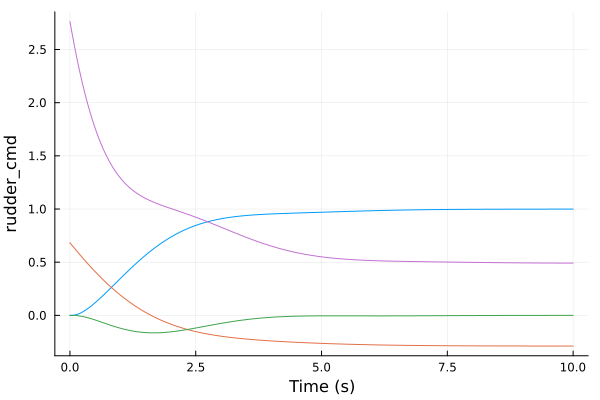

In [278]:
φsp2φ_SAS = P_φβ[:φ, :φ_sp]
φsp2β_SAS = P_φβ[:β, :φ_sp]
φsp2ail_SAS = P_φβ[:aileron_cmd, :φ_sp]
φsp2rud_SAS = P_φβ[:rudder_cmd, :φ_sp]
step(φsp2φ_SAS, 10) |> plot
step(φsp2ail_SAS, 10) |> plot!
step(φsp2β_SAS, 10) |> plot!
step(φsp2rud_SAS, 10) |> plot!

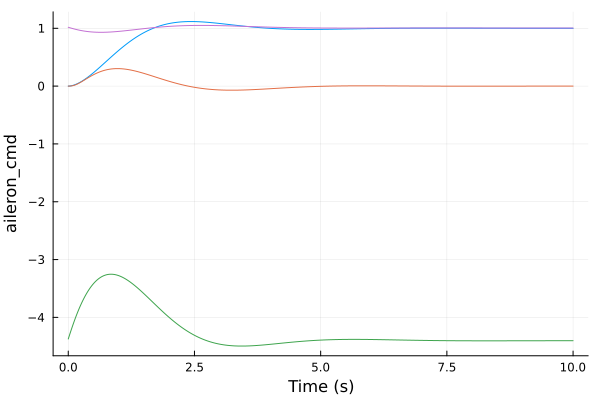

In [279]:
βsp2β_SAS = P_φβ[:β, :β_sp]
βsp2φ_SAS = P_φβ[:φ, :β_sp]
βsp2rud_SAS = P_φβ[:rudder_cmd, :β_sp]
βsp2ail_SAS = P_φβ[:aileron_cmd, :β_sp]
step(βsp2β_SAS, 10) |> plot
step(βsp2φ_SAS, 10) |> plot!
step(βsp2rud_SAS, 10) |> plot!
step(βsp2ail_SAS, 10) |> plot!

Beautiful. Now that we know that $\phi$ and $\beta$ work well, we can repeat the design with added integral control in $\beta$.

### 2.2. Design B (Integral $\beta$ Control)

In [280]:
#define command variables
z_labels = [:φ, :β]
@assert tuple(z_labels...) === propertynames(C172XControl.ZLat())
z_trim = lss_red.y0[z_labels]
n_z = length(z_labels)

F = lss_red.A
G = lss_red.B
Hx = lss_red.C[z_labels, :]
Hu = lss_red.D[z_labels, :]
display(Hx)
display(Hu)

#define the blocks corresponding to the subset of the command variables for
#which integral compensation is required. in this case, only one of them (β).
#Since the resulting blocks have only one row, we get vectors, which we need to
#transpose to get the desired row matrices back.
Hx_int = Hx[:β, :]'
Hu_int = Hu[:β, :]'
n_int, _ = size(Hx_int)
display(Hx_int)
display(Hu_int)

F_aug = [F zeros(n_x, n_int); Hx_int zeros(n_int, n_int)]
G_aug = [G; Hu_int]
Hx_aug = [Hx zeros(n_z, n_int)]
Hu_aug = Hu

P_aug = ss(F_aug, G_aug, Hx_aug, Hu_aug)
controllability(F_aug, G_aug)

2×8 ComponentMatrix{Float64} with axes Axis(φ = 1, β = 2) × Axis(p = 1, r = 2, φ = 3, v_x = 4, v_y = 5, β_filt = 6, ail_p = 7, rud_p = 8)
 0.0  0.0  1.0  0.0  0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0380432  0.0  0.0  0.0

2×2 ComponentMatrix{Float64} with axes Axis(φ = 1, β = 2) × Axis(aileron_cmd = 1, rudder_cmd = 2)
 0.0  0.0
 0.0  0.0

1×8 adjoint(::ComponentVector{Float64, Vector{Float64}, Tuple{Axis{(p = 1, r = 2, φ = 3, v_x = 4, v_y = 5, β_filt = 6, ail_p = 7, rud_p = 8)}}}) with eltype Float64 with indices Base.OneTo(1)×1:1:8:
 0.0  0.0  0.0  0.0  0.0380432  0.0  0.0  0.0

1×2 adjoint(::ComponentVector{Float64, Vector{Float64}, Tuple{Axis{(aileron_cmd = 1, rudder_cmd = 2)}}}) with eltype Float64 with indices Base.OneTo(1)×1:1:2:
 0.0  0.0

(iscontrollable = true, ranks = [9, 9, 9, 9, 9, 9, 9, 9, 9], sigma_min = [0.04656158490674126, 10.444104186843441, 10.444104186843441, 0.8968479773851336, 0.04172114707136558, 0.3656273601240532, 0.3656273601240532, 0.03719813175522497, 0.10603780560834498])

In [281]:
@unpack v_x, v_y = lss_red.x0
v_norm = norm([v_x, v_y])

#weight matrices
Q = ComponentVector(p = 0, r = 0.1, φ = 0.15, v_x = 0/v_norm, v_y = 0.1/v_norm, β_filt = 0, ail_p = 0, rud_p = 0, ξ_β = 0.001) |> diagm
R = C172XControl.ULat(aileron_cmd = 0.1, rudder_cmd = 0.05) |> diagm

#compute gain matrix
C_aug = lqr(P_aug, Q, R)

# quickly construct the closed-loop augmented system to check the resulting
# eigenvalues, we'll do the connections properly later
F_aug_cl = F_aug - G_aug * C_aug
P_aug_cl = ss(F_aug_cl, G_aug, Hx_aug, Hu_aug)

dampreport(P_aug)
dampreport(P_aug_cl)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| +0                 |  -1           |  0            |  0            |  -Inf         |
| +0.0993            |  -1           |  0.0993       |  0.0158       |  -10.1        |
| -0.622             |  1            |  0.622        |  0.099        |  1.61         |
| -0.499  ±   1.42im |  0.332        |  1.51         |  0.24         |  2            |
| -5.1               |  1            |  5.1          |  0.811        |  0.196        |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -50                |  1            |  50           |  7.96         |  0.02         |
|        Pole        |   Damping     |   Fr

In [282]:
A = [F G; Hx Hu]
B = inv(A)
B_12 = B[1:n_x, n_x+1:end]
B_22 = B[n_x+1:end, n_x+1:end]

#extract system state and integrator blocks from the feedback matrix
C_x = C_aug[:, 1:n_x]
C_ξ = C_aug[:, n_x+1:end]

C_fbk = C_x
C_fwd = B_22 + C_x * B_12
C_int = ComponentMatrix(zeros(n_u, n_z), Axis(u_labels), Axis(z_labels))
C_int[:, :β] .= C_ξ

#some useful signal labels
u_labels_fbk = Symbol.(string.(u_labels) .* "_fbk")
u_labels_fwd = Symbol.(string.(u_labels) .* "_fwd")
u_labels_sum = Symbol.(string.(u_labels) .* "_sum")
u_labels_int_u = Symbol.(string.(u_labels) .* "_int_u")
u_labels_int = Symbol.(string.(u_labels) .* "_int")
u_labels_ξ = Symbol.(string.(u_labels) .* "_ξ")

z_labels_sp = Symbol.(string.(z_labels) .* "_sp")
z_labels_sp1 = Symbol.(string.(z_labels) .* "_sp1")
z_labels_sp2 = Symbol.(string.(z_labels) .* "_sp2")
z_labels_err = Symbol.(string.(z_labels) .* "_err")
z_labels_sum = Symbol.(string.(z_labels) .* "_sum")
z_labels_sp_fwd = Symbol.(string.(z_labels) .* "_sp_fwd")
z_labels_sp_sum = Symbol.(string.(z_labels) .* "_sp_sum")

#the integral gain matrix is constructed by padding C_ξ with zeros in those
#columns corresponding to command variables without integral compensation
C_fbk_ss = named_ss(ss(C_fbk), u = x_labels_red, y = u_labels_fbk)
C_fwd_ss = named_ss(ss(C_fwd), u = z_labels_sp_fwd, y = u_labels_fwd)
C_int_ss = named_ss(ss(C_int), u = z_labels_err, y = u_labels_int_u)

int_ss = named_ss(ss(tf(1, [1,0])) .* I(2),
                    x = u_labels_ξ,
                    u = u_labels_int_u,
                    y = u_labels_int);

φ_err_sum = sumblock("φ_err = φ_sum - φ_sp_sum")
β_err_sum = sumblock("β_err = β_sum - β_sp_sum")

aileron_cmd_sum = sumblock("aileron_cmd_sum = aileron_cmd_fwd - aileron_cmd_fbk - aileron_cmd_int")
rudder_cmd_sum = sumblock("rudder_cmd_sum = rudder_cmd_fwd - rudder_cmd_fbk - rudder_cmd_int")

φ_sp_splitter = splitter(:φ_sp, 2)
β_sp_splitter = splitter(:β_sp, 2)

connections = vcat(
    Pair.(x_labels_red, x_labels_red),
    Pair.(z_labels, z_labels_sum),
    Pair.(z_labels_sp1, z_labels_sp_sum),
    Pair.(z_labels_sp2, z_labels_sp_fwd),
    Pair.(z_labels_err, z_labels_err),
    Pair.(u_labels_sum, u_labels),
    Pair.(u_labels_fwd, u_labels_fwd),
    Pair.(u_labels_fbk, u_labels_fbk),
    Pair.(u_labels_int, u_labels_int),
    Pair.(u_labels_int_u, u_labels_int_u),
    )

display(C_fbk_ss)
display(C_fwd_ss)
display(C_int_ss)

NamedStateSpace{Continuous, Float64}
D = 
  0.2972598798755536    -0.5083412178484191  1.4810470159337146    0.004128949507598055    0.09176972220520137  0.0   0.07064671515804041  -0.01600504535746594
 -0.055688005371531936   2.2473365417188673  0.034007261429349296  0.0030917514005401963  -0.0946145090285336   0.0  -0.03201009071493188   0.04299843790949702

Continuous-time state-space model
With state  names: 
     input  names: p r φ v_x v_y β_filt ail_p rud_p
     output names: aileron_cmd_fbk rudder_cmd_fbk


NamedStateSpace{Continuous, Float64}
D = 
 0.9606030276722264   3.5629221333233003
 1.3436598966123836  -7.166822505073106

Continuous-time state-space model
With state  names: 
     input  names: φ_sp_fwd β_sp_fwd
     output names: aileron_cmd_fwd rudder_cmd_fwd


NamedStateSpace{Continuous, Float64}
D = 
 0.0   0.07032133552848194
 0.0  -0.10054759837530079

Continuous-time state-space model
With state  names: 
     input  names: φ_err β_err
     output names: aileron_cmd_int_u rudder_cmd_int_u


Now, after designing the LQR tracker on the reduced plant, we connect it to the full lateral dynamics to get $\psi$ and $\chi$ back for later.

In [283]:
P_φβ = connect([P_full, int_ss, C_fwd_ss, C_fbk_ss, C_int_ss,
                φ_err_sum, β_err_sum,
                aileron_cmd_sum, rudder_cmd_sum,
                φ_sp_splitter, β_sp_splitter], connections;
                w1 = z_labels_sp, z1 = y_labels_full)

dampreport(P_φβ)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -4.2e-13           |  1            |  4.2e-13      |  6.69e-14     |  2.38e+12     |
| +8.11e-08          |  -1           |  8.11e-08     |  1.29e-08     |  -1.23e+07    |
| -0.0165            |  1            |  0.0165       |  0.00263      |  60.6         |
| -0.623             |  1            |  0.623        |  0.0991       |  1.61         |
| -0.771             |  1            |  0.771        |  0.123        |  1.3          |
| -1.25   ±   1.69im |  0.596        |  2.1          |  0.335        |  0.797        |
| -4.98              |  1            |  4.98         |  0.793        |  0.201        |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -20                |  1            |  20 

┌ Warning: Connecting single output to multiple inputs Y1=Union{Nothing, Int64}[1, 2, 4, 5, 6, 7, 8, 9, 4, 11, 27, 29, 28, 30, 23, 24, 25, 26, 17, 18, 19, 20, 15, 16, 21, 22]
└ @ ControlSystemsBase /Users/miguel/.julia/packages/ControlSystemsBase/NYWcD/src/connections.jl:344


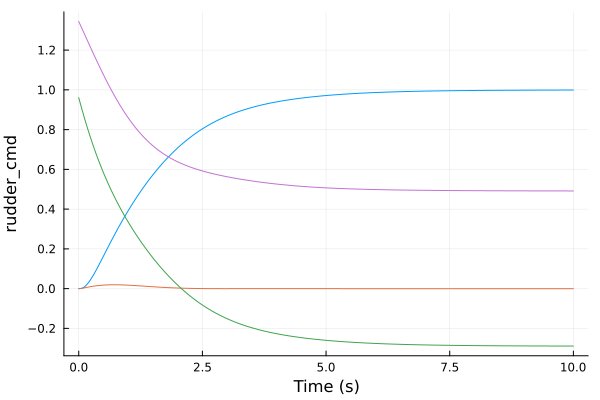

In [284]:
φsp2φ_φβ = P_φβ[:φ, :φ_sp]
φsp2β_φβ = P_φβ[:β, :φ_sp]
φsp2ail_φβ = P_φβ[:aileron_cmd, :φ_sp]
φsp2rud_φβ = P_φβ[:rudder_cmd, :φ_sp]
step(φsp2φ_φβ, 10) |> plot
step(φsp2β_φβ, 10) |> plot!
step(φsp2ail_φβ, 10) |> plot!
step(φsp2rud_φβ, 10) |> plot!

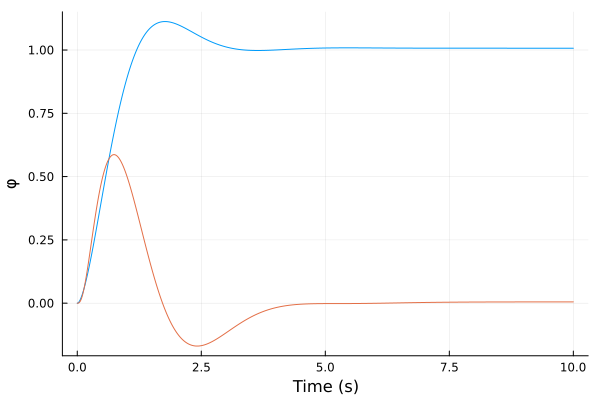

In [285]:
βsp2β_φβ = P_φβ[:β, :β_sp]
βsp2φ_φβ = P_φβ[:φ, :β_sp]
βsp2rud_φβ = P_φβ[:rudder_cmd, :β_sp]
βsp2ail_φβ = P_φβ[:aileron_cmd, :β_sp]
step(βsp2β_φβ, 10) |> plot
step(βsp2φ_φβ, 10) |> plot!
# step(βsp2rud_φβ, 10) |> plot!
# step(βsp2ail_φβ, 10) |> plot!

### 2.3. Design C (Integral $\phi$ and $\beta$ Control)

In [286]:
#define command variables
z_labels = [:φ, :β]
@assert tuple(z_labels...) === propertynames(C172XControl.ZLat())
z_trim = lss_red.y0[z_labels]
n_z = length(z_labels)

2

In [287]:
F = lss_red.A
G = lss_red.B
Hx = lss_red.C[z_labels, :]
Hu = lss_red.D[z_labels, :]
display(Hx)
display(Hu)

#define the blocks corresponding to the subset of the command variables for
#which integral compensation is required
Hx_int = Hx[z_labels, :]
Hu_int = Hu[z_labels, :]
n_int, _ = size(Hx_int)
display(Hx_int)
display(Hu_int)

F_aug = [F zeros(n_x, n_int); Hx_int zeros(n_int, n_int)]
G_aug = [G; Hu_int]
Hx_aug = [Hx zeros(n_z, n_int)]
Hu_aug = Hu

P_aug = ss(F_aug, G_aug, Hx_aug, Hu_aug)
controllability(F_aug, G_aug)

2×8 ComponentMatrix{Float64} with axes Axis(φ = 1, β = 2) × Axis(p = 1, r = 2, φ = 3, v_x = 4, v_y = 5, β_filt = 6, ail_p = 7, rud_p = 8)
 0.0  0.0  1.0  0.0  0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0380432  0.0  0.0  0.0

2×2 ComponentMatrix{Float64} with axes Axis(φ = 1, β = 2) × Axis(aileron_cmd = 1, rudder_cmd = 2)
 0.0  0.0
 0.0  0.0

2×8 ComponentMatrix{Float64} with axes Axis(φ = 1, β = 2) × Axis(p = 1, r = 2, φ = 3, v_x = 4, v_y = 5, β_filt = 6, ail_p = 7, rud_p = 8)
 0.0  0.0  1.0  0.0  0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0380432  0.0  0.0  0.0

2×2 ComponentMatrix{Float64} with axes Axis(φ = 1, β = 2) × Axis(aileron_cmd = 1, rudder_cmd = 2)
 0.0  0.0
 0.0  0.0

(iscontrollable = true, ranks = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10], sigma_min = [0.04656158489773627, 10.443722055306749, 10.443722055306749, 0.8967568621836421, 0.04122729377352777, 0.3614008593783047, 0.3614008593783047, 0.03683748835282287, 0.03683748835282287, 0.10578869627372456])

In [288]:
@unpack v_x, v_y = lss_red.x0
v_norm = norm([v_x, v_y])

#weight matrices
Q = ComponentVector(p = 0, r = 0.1, φ = 0.25, v_x = 0/v_norm, v_y = 0.1/v_norm, β_filt = 0, ail_p = 0, rud_p = 0, ξ_φ = 0.1, ξ_β = 0.001) |> diagm
R = C172XControl.ULat(aileron_cmd = 0.05, rudder_cmd = 0.05) |> diagm

#compute gain matrix
C_aug = lqr(P_aug, Q, R)

# quickly construct the closed-loop augmented system to check the resulting
# eigenvalues, we'll do the connections properly later
F_aug_cl = F_aug - G_aug * C_aug
P_aug_cl = ss(F_aug_cl, G_aug, Hx_aug, Hu_aug)

dampreport(P_aug)
dampreport(P_aug_cl)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| +0                 |  -1           |  0            |  0            |  -Inf         |
| +0                 |  -1           |  0            |  0            |  -Inf         |
| +0.0993            |  -1           |  0.0993       |  0.0158       |  -10.1        |
| -0.622             |  1            |  0.622        |  0.099        |  1.61         |
| -0.499  ±   1.42im |  0.332        |  1.51         |  0.24         |  2            |
| -5.1               |  1            |  5.1          |  0.811        |  0.196        |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -50                |  1            |  50 

In [289]:
A = [F G; Hx Hu]
B = inv(A)
B_12 = B[1:n_x, n_x+1:end]
B_22 = B[n_x+1:end, n_x+1:end]

#extract system state and integrator blocks from the feedback matrix
C_x = C_aug[:, 1:n_x]
C_ξ = C_aug[:, n_x+1:end]

C_fbk = C_x
C_fwd = B_22 + C_x * B_12
C_int = C_ξ

#some useful signal labels
u_labels_fbk = Symbol.(string.(u_labels) .* "_fbk")
u_labels_fwd = Symbol.(string.(u_labels) .* "_fwd")
u_labels_sum = Symbol.(string.(u_labels) .* "_sum")
u_labels_int_u = Symbol.(string.(u_labels) .* "_int_u")
u_labels_int = Symbol.(string.(u_labels) .* "_int")
u_labels_ξ = Symbol.(string.(u_labels) .* "_ξ")

z_labels_sp = Symbol.(string.(z_labels) .* "_sp")
z_labels_sp1 = Symbol.(string.(z_labels) .* "_sp1")
z_labels_sp2 = Symbol.(string.(z_labels) .* "_sp2")
z_labels_err = Symbol.(string.(z_labels) .* "_err")
z_labels_sum = Symbol.(string.(z_labels) .* "_sum")
z_labels_sp_fwd = Symbol.(string.(z_labels) .* "_sp_fwd")
z_labels_sp_sum = Symbol.(string.(z_labels) .* "_sp_sum")

#the integral gain matrix is constructed by padding C_ξ with zeros in those
#columns corresponding to command variables without integral compensation
C_fbk_ss = named_ss(ss(C_fbk), u = x_labels_red, y = u_labels_fbk)
C_fwd_ss = named_ss(ss(C_fwd), u = z_labels_sp_fwd, y = u_labels_fwd)
C_int_ss = named_ss(ss(C_int), u = z_labels_err, y = u_labels_int_u)

int_ss = named_ss(ss(tf(1, [1,0])) .* I(2),
                    x = u_labels_ξ,
                    u = u_labels_int_u,
                    y = u_labels_int);

φ_err_sum = sumblock("φ_err = φ_sum - φ_sp_sum")
β_err_sum = sumblock("β_err = β_sum - β_sp_sum")

aileron_cmd_sum = sumblock("aileron_cmd_sum = aileron_cmd_fwd - aileron_cmd_fbk - aileron_cmd_int")
rudder_cmd_sum = sumblock("rudder_cmd_sum = rudder_cmd_fwd - rudder_cmd_fbk - rudder_cmd_int")

φ_sp_splitter = splitter(:φ_sp, 2)
β_sp_splitter = splitter(:β_sp, 2)

connections = vcat(
    Pair.(x_labels_red, x_labels_red),
    Pair.(z_labels, z_labels_sum),
    Pair.(z_labels_sp1, z_labels_sp_sum),
    Pair.(z_labels_sp2, z_labels_sp_fwd),
    Pair.(z_labels_err, z_labels_err),
    Pair.(u_labels_sum, u_labels),
    Pair.(u_labels_fwd, u_labels_fwd),
    Pair.(u_labels_fbk, u_labels_fbk),
    Pair.(u_labels_int, u_labels_int),
    Pair.(u_labels_int_u, u_labels_int_u),
    )

display(C_fbk_ss)
display(C_fwd_ss)
display(C_int_ss)

NamedStateSpace{Continuous, Float64}
D = 
 0.5665470313941599   0.02766557035081478  3.257611820956148   0.006533070522910567   0.12901363798739168  0.0   0.1219532016685976    -0.011560208588625618
 0.07151927481723622  2.838590573935344    0.9052028510554946  0.004383270032243717  -0.10287127826980212  0.0  -0.011560208588625618   0.05141305330165763

Continuous-time state-space model
With state  names: 
     input  names: p r φ v_x v_y β_filt ail_p rud_p
     output names: aileron_cmd_fbk rudder_cmd_fbk


NamedStateSpace{Continuous, Float64}
D = 
 2.8886148361271813   4.559243012229717
 2.408648011852255   -7.414945077013131

Continuous-time state-space model
With state  names: 
     input  names: φ_sp_fwd β_sp_fwd
     output names: aileron_cmd_fwd rudder_cmd_fwd


NamedStateSpace{Continuous, Float64}
D = 
 1.2002839090876092   0.07478760175225653
 0.74787601752319    -0.12002839090835402

Continuous-time state-space model
With state  names: 
     input  names: φ_err β_err
     output names: aileron_cmd_int_u rudder_cmd_int_u


Now, after designing the LQR tracker on the reduced plant, we connect it to the full lateral dynamics to get $\psi$ and $\chi$ back for later.

In [290]:
P_φβ = connect([P_full, int_ss, C_fwd_ss, C_fbk_ss, C_int_ss,
                φ_err_sum, β_err_sum,
                aileron_cmd_sum, rudder_cmd_sum,
                φ_sp_splitter, β_sp_splitter], connections;
                w1 = z_labels_sp, z1 = y_labels_full)

dampreport(P_φβ)

|        Pole        |   Damping     |   Frequency   |   Frequency   | Time Constant |
|                    |    Ratio      |   (rad/sec)   |     (Hz)      |     (sec)     |
+--------------------+---------------+---------------+---------------+---------------+
| -6.07e-07          |  1            |  6.07e-07     |  9.66e-08     |  1.65e+06     |
| -0.0164            |  1            |  0.0164       |  0.00261      |  61.1         |
| -0.623             |  1            |  0.623        |  0.0991       |  1.61         |
| -0.887  ± 0.0818im |  0.996        |  0.891        |  0.142        |  1.13         |
| -1.49   ±    1.6im |  0.682        |  2.19         |  0.349        |  0.669        |
| -4.7               |  1            |  4.7          |  0.747        |  0.213        |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -20                |  1            |  20           |  3.18         |  0.05         |
| -50                |  1            |  50 

┌ Warning: Connecting single output to multiple inputs Y1=Union{Nothing, Int64}[1, 2, 4, 5, 6, 7, 8, 9, 4, 11, 27, 29, 28, 30, 23, 24, 25, 26, 17, 18, 19, 20, 15, 16, 21, 22]
└ @ ControlSystemsBase /Users/miguel/.julia/packages/ControlSystemsBase/NYWcD/src/connections.jl:344


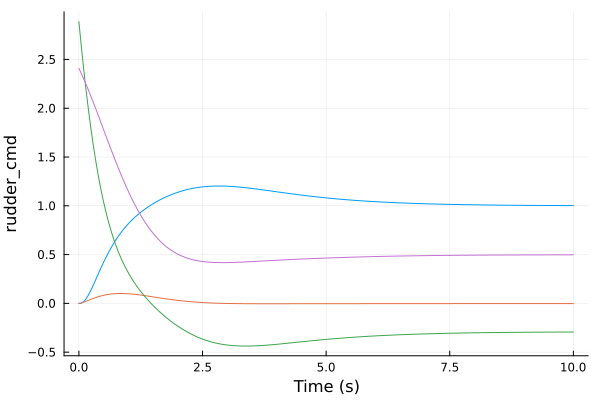

In [291]:
φsp2φ_φβ = P_φβ[:φ, :φ_sp]
φsp2β_φβ = P_φβ[:β, :φ_sp]
φsp2ail_φβ = P_φβ[:aileron_cmd, :φ_sp]
φsp2rud_φβ = P_φβ[:rudder_cmd, :φ_sp]
step(φsp2φ_φβ, 10) |> plot
step(φsp2β_φβ, 10) |> plot!
step(φsp2ail_φβ, 10) |> plot!
step(φsp2rud_φβ, 10) |> plot!

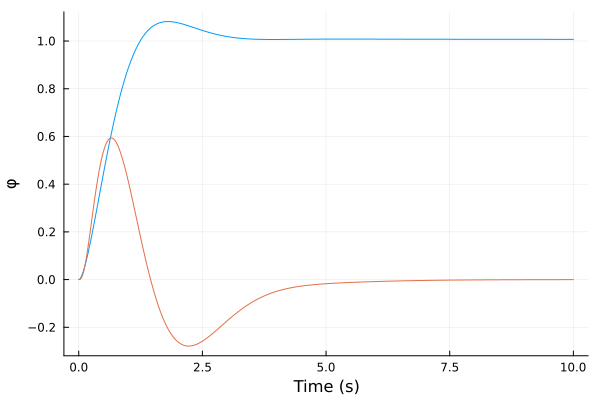

In [292]:
βsp2β_φβ = P_φβ[:β, :β_sp]
βsp2φ_φβ = P_φβ[:φ, :β_sp]
βsp2rud_φβ = P_φβ[:rudder_cmd, :β_sp]
βsp2ail_φβ = P_φβ[:aileron_cmd, :β_sp]
step(βsp2β_φβ, 10) |> plot
step(βsp2φ_φβ, 10) |> plot!
# step(βsp2rud_φβ, 10) |> plot!
# step(βsp2ail_φβ, 10) |> plot!

## 3. Roll Rate Control Augmentation

We now design a roll rate CAS on top of the plant with $\phi$ and $\beta$ tracking. This will be a
SISO loop connected to the $\phi_{sp}$ input. That is, we will provide roll rate tracking via the
bank angle set point. Clearly, one integrator will be needed in the feedforward path to yield a
type-0 open-loop system. And another one to achieve type 1 (zero steady-state roll rate error).

In [ ]:
P_φ2p = P_φβ[:p, :φ_sp];
step(P_φ2p, 10) |> plot

In [ ]:
bodeplot(P_φ2p)

In [ ]:
nyquistplot(P_φ2p; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))

In [ ]:
p2φ_int = tf(1, [1, 0]) |> ss
P_p2φ_opt = series(p2φ_int, ss(P_φ2p))

t_sim_p2φ = 10
lower_bounds = PIDParams(; k_p = 0.1, k_i = 0.0, k_d = 0.0, τ_f = 0.01)
upper_bounds = PIDParams(; k_p = 10.0, k_i = 35.0, k_d = 1.5, τ_f = 0.01)
settings = Settings(; t_sim = t_sim_p2φ, lower_bounds, upper_bounds)
weights = Metrics(; Ms = 1, ∫e = 10, ef = 2, ∫u = 0.1, up = 0.00)
params_0 = PIDParams(; k_p = 1.5, k_i = 3, k_d = 0.1, τ_f = 0.01)

p2φ_results = optimize_PID(P_p2φ_opt; params_0, settings, weights, global_search)

@unpack k_p, k_i, k_d, T_i, T_d = p2φ_results.params
@unpack k_p, k_i, k_d, T_i, T_d = p2φ_results.params
@show k_p, k_i, k_d, T_i, T_d
@show p2φ_results.metrics
@show p2φ_results.exit_flag

In [ ]:
p2φ_PID = build_PID(p2φ_results.params)
C_p2φ = named_ss(series(p2φ_int, p2φ_PID), :C_p2φ; u = :p_err, y = :φ_sp)

In [ ]:
#steady-state error for a unit step input, now zero
L_p2φ = series(C_p2φ, P_φ2p)

T_p2φ = output_comp_sensitivity(P_φ2p, C_p2φ) #this is the closed loop transfer function
T_p2φ_step = step(T_p2φ, t_sim_p2φ)
stepinfo(T_p2φ_step) |> display
T_p2φ_step |> plot

In [ ]:
marginplot(L_p2φ)

In [ ]:
gangoffourplot(P_φ2p, C_p2φ)

In [ ]:
p2φ_sum = sumblock("p_err = p_sp - p")
P_pβ = connect([P_φβ, p2φ_sum, C_p2φ], [:p_err=>:p_err, :p=>:p, :φ_sp=>:φ_sp], w1 = [:p_sp, :β_sp], z1 = P_φβ.y)

#check we get the same response as with the SISO closed loop
psp2p = P_pβ[:p, :p_sp]
psp2β = P_pβ[:β, :p_sp]
psp2a = P_pβ[:aileron_cmd, :p_sp]
psp2r = P_pβ[:rudder_cmd, :p_sp]
step(psp2p, t_sim_p2φ) |> plot
step(psp2β, t_sim_p2φ) |> plot!
step(psp2a, t_sim_p2φ) |> plot!
step(psp2r, t_sim_p2φ) |> plot!

To avoid transients on mode changes, we want the initial output of the roll rate loop to match the current value of the bank angle setpoint at the roll-yaw SAS input, $\phi_{sp}$.

Whenever roll rate mode is enabled after a mode change, we first reset both the integrator and the PID. Then we set PID integrator's state to the appropriate value to achieve the required $\phi_{sp}$. We have:
$$ y_{int} = 0 $$
$$ y_{pid} = k_p y_{int} + k_i x_{i0} = k_i x_{i0} = \phi_{sp} $$

Therefore:
$$x_{i0} = \phi_{sp}/k_i$$

## 4. Course Angle Tracker

We start from the plant with embedded bank angle and sideslip control.

In [ ]:
P_φ2χ = P_φβ[:χ, :φ_sp];
bodeplot(P_φ2χ)
step(P_φ2χ, 10) |> plot

In [ ]:
marginplot(P_φ2χ)

In [ ]:
nyquistplot(P_φ2χ; unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))

We can see that without compensation the loop transfer function is already type-1, that is, gain goes to infinity for zero frequency. This ensures zero steady-state error, but not in the presence of external disturbances (such as crosswind). For zero steady-state disturbances rejection we need integral compensation. The result is a type 2 open loop system.

In [ ]:
t_sim_χ2φ = 30
lower_bounds = PIDParams(; k_p = 0.1, k_i = 0.5, k_d = 0.0, τ_f = 0.01)
upper_bounds = PIDParams(; k_p = 10.0, k_i = 0.5, k_d = 0.0, τ_f = 0.01)
settings = Settings(; t_sim = t_sim_χ2φ, lower_bounds, upper_bounds)
weights = Metrics(; Ms = 1, ∫e = 10, ef = 1, ∫u = 0.00, up = 0.01)
params_0 = PIDParams(; k_p = 3., k_i = 0.4, k_d = 0.0, τ_f = 0.01)

χ2φ_results = optimize_PID(P_φ2χ; params_0, settings, weights, global_search)
χ2φ_PID = build_PID(χ2φ_results.params)
C_χ2φ = named_ss(χ2φ_PID, :C_χ2φ; u = :χ_err, y = :φ_sp);

@unpack k_p, k_i, k_d, T_i, T_d = χ2φ_results.params
@show k_p, k_i, k_d, T_i, T_d
@show χ2φ_results.metrics
@show χ2φ_results.exit_flag

In [ ]:
L_χ2φ = series(C_χ2φ, P_φ2χ)
nyquistplot(L_χ2φ, unit_circle = true, Ms_circles = [1.0])
plot!(ylims = (-2,2), xlims = (-2,2))

In [ ]:
marginplot(L_χ2φ)

Here we are particularly interested in the load disturbance to output transfer function P/(1+C). In order for the controller to be able to counter the effects of crosswind, this function needs to show low frequency roll-off. And indeed, forcing a nonzero integral term in the PID achieves this goal.

In [ ]:
gangoffourplot(P_φ2χ, C_χ2φ)

In [ ]:
T_χ2φ = output_comp_sensitivity(P_φ2χ, C_χ2φ) #input to output response
T_χ2φ_step = step(T_χ2φ, 2t_sim_χ2φ)
stepinfo(T_χ2φ_step) |> display
T_χ2φ_step |> plot

The drawback of the forced inclusion of integral action is an undesirably large overshoot. However, for the step response it is also important to consider the input to control signal response, because obviously our bank angle demand will be limited. 

And in this case, saturation will work in our favor. For large initial step responses, it will halt integration before the integrator's state reaches the values predicted by the linear model. Therefore, the actual overshoot will be smaller.

In [ ]:
CS_χ2φ = G_CS(P_φ2χ, C_χ2φ) #input to control signal response
CS_χ2φ_step = step(CS_χ2φ, t_sim_χ2φ)
CS_χ2φ_step |> plot!

In [ ]:
χ2φ_sum = sumblock("χ_err = χ_sp - χ")
P_χβ = connect([P_φβ, χ2φ_sum, C_χ2φ], [:χ_err=>:χ_err, :χ=>:χ, :φ_sp=>:φ_sp], w1 = [:χ_sp, :β_sp], z1 = P_φβ.y)

#check we get the same response as with the SISO closed loop
χsp2χ = P_χβ[:χ, :χ_sp]
χsp2β = P_χβ[:β, :χ_sp]
χsp2a = P_χβ[:aileron_cmd, :χ_sp]
step(χsp2χ, t_sim_χ2φ) |> plot
step(χsp2β, t_sim_χ2φ) |> plot!
step(χsp2a, t_sim_χ2φ) |> plot!

To avoid transients on mode changes, we want the initial output of the course angle loop to match the current value of the bank angle setpoint at the roll-yaw SAS input, $\phi_{sp}$.

Whenever $\chi2\phi$ is enabled after a mode change, we reset the PID. Then we set the PID integrator's state to the appropriate value to achieve the required $\phi$. We have:
$$ y_{pid} = k_p (\chi_{sp} - \chi) + k_i x_{i0} = k_i x_{i0} $$
$$ \phi_{sp} = y_{pid}$$

Therefore:
$$x_{i0} = y_{pid} / k_i = \phi_{sp}/k_i = \phi/k_i$$